# 1. Setup

In [26]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Optional

# Custom utils for rasterio
from src.data_loading.rasterio_utils import get_thumbnail, read_from_lat_lon
from src.data_loading.landcover_plot_utils import classes_to_rgb

# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR

# For loading geotiff data
import rasterio

# For performing geospatial analysis
import pylandstats as pls

# For conveniently getting longitude, latitude from name (& geodesic distances)
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="landcover_data_exploration")

# 2. Data loading

In [28]:
# Load sample data file:
landcover_2015_path = (
    ESA_LANDCOVER_DIR / "ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"
)

# Parse land cover classes:
landcover_2015_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_2015_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


## 2.1 Load geotiff via pylandstats

Note: Don't run the cell below. It will take a long time and overload memory. pls does not do lazy loading apparently

In [29]:
# landcover_2015 = pls.Landscape(landcover_2015_path)

## 2.2 Load via rasterio

In [30]:
dataset = rasterio.open(landcover_2015_path)

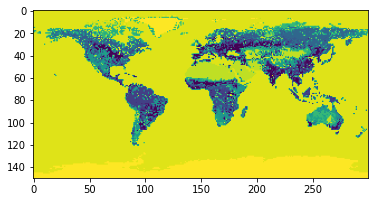

In [31]:
thumbnail = get_thumbnail(dataset, height=150)
plt.imshow(thumbnail)

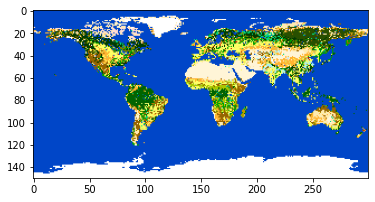

In [33]:
# To plot this with the colors defined by ESA CCI
plt.imshow(classes_to_rgb(thumbnail))

## Getting to know rasterio

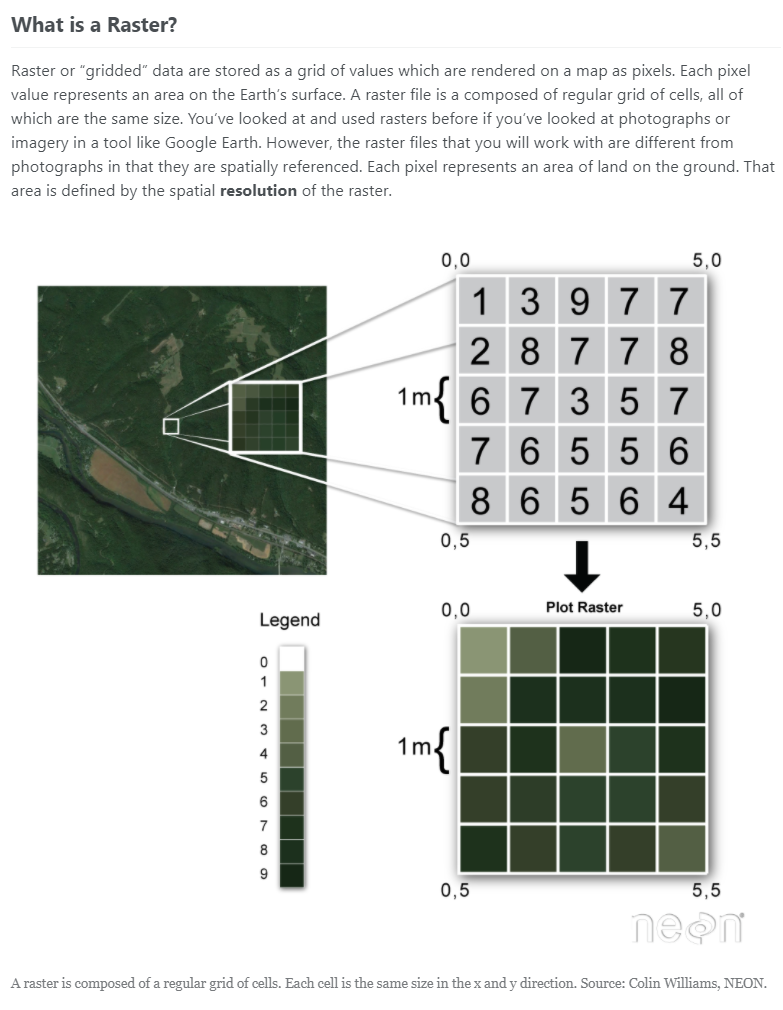

#### How to get dataset metadata?

In [32]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 129600,
 'height': 64800,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.002777777777778, 0.0, -180.0,
        0.0, -0.002777777777778, 90.0)}

In [33]:
dataset.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 129600, 'height': 64800, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.002777777777778, 0.0, -180.0,
       0.0, -0.002777777777778, 90.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [35]:
dataset.tags()

{'AREA_OR_POINT': 'Area',
 'Copyright': 'ESA 2017 - UCLouvain',
 'Dataset': 'Global annual land cover map at 300 m based on the full archives of 300 m MERIS, 1 km SPOT-VEGETATION, 1 km PROBA-V and 1 km AVHRR surface reflectance 7-day composites',
 'Description': 'Pixel value corresponds to the label of a land cover class defined using UN-LCCS classifiers',
 'Scaling Factor': 'none',
 'Version': '2.0.7'}

#### How to get tif dimensions?

In [36]:
print(dataset.height, dataset.width)

64800 129600


#### How to go from coordinate data (latitude, longitude) to pixel index data (i, j) in rasterio?

In [49]:
# Chernobyl:
chernobyl_lat = 51.27
chernobyl_lon = 30.22

# Pixel coordinates:
dataset.index(x=chernobyl_lat, y=chernobyl_lon)

# Note:
# This calculates ~dataset.transform * (x,y) under the hood and returns it in flipped order

(21520, 83257)

#### How to go from pixel values (i,j) to (latitude, longitude)?

In [50]:
dataset.xy(
    21520, 83257
)  # Under the hood this calculates: dataset.transform * (px_j, px_i)

(51.270833333351845, 30.220833333328557)

In [51]:
# Chernobyl pixels
px_i = 21520
px_j = 83257

# Latitude longitude:
dataset.transform * (px_j, px_i)  # note the flipped order of (i,j here)

(51.26944444446295, 30.22222222221744)

#### How to get the inverse of a transform? 

In [18]:
inv_transform = ~dataset.transform
inv_transform

Affine(359.99999999997124, 0.0, 64799.99999999482,
       0.0, -359.99999999997124, 32399.99999999741)

#### How to read in a certain pixel area (top left pixel to bottom right pixel) in rasterio?

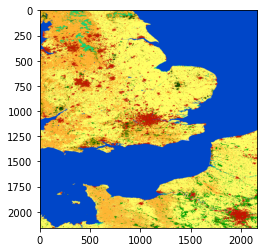

In [35]:
london = geolocator.geocode("London")
offset = 3

tmp_data = read_from_lat_lon(
    dataset,
    1,
    lat=london.latitude + np.array([-offset, offset]),
    lon=london.longitude + np.array([-offset, offset]),
)

plt.imshow(classes_to_rgb(tmp_data))

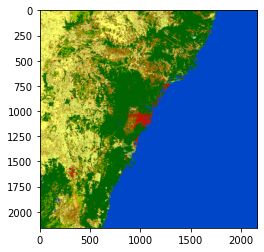

In [36]:
sidney = geolocator.geocode("Sidney")

tmp_data = read_from_lat_lon(
    dataset,
    1,
    lat=sidney.latitude + np.array([-offset, offset]),
    lon=sidney.longitude + np.array([-offset, offset]),
)

plt.imshow(classes_to_rgb(tmp_data))

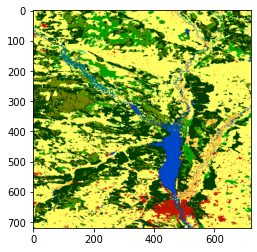

In [38]:
chernobyl = geolocator.geocode("Chernobyl")
offset = 1

tmp_data = read_from_lat_lon(
    dataset,
    1,
    lat=chernobyl.latitude + np.array([-offset, offset]),
    lon=chernobyl.longitude + np.array([-offset, offset]),
)

plt.imshow(classes_to_rgb(tmp_data))

# 3. Let's use the pylandstats package to calculate some landstats for the region around London

In [22]:
chernobyl_area = pls.Landscape(tmp_data, res=(300, 300))

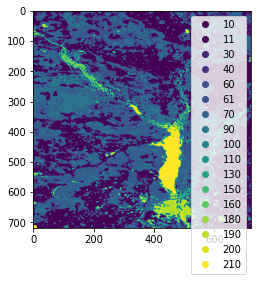

In [23]:
chernobyl_area.plot_landscape(legend=True)

In [75]:
patch_metrics_df = chernobyl_area.compute_patch_metrics_df()

In [76]:
patch_metrics_df

,class_val,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension,euclidean_nearest_neighbor
patch_id,,,,,,,
0,10,32670.0,870000,26.629936,11.983471,1.253786,600.000000
1,10,99.0,4800,48.484848,1.142857,1.027141,1081.665383
2,10,9.0,1200,133.333333,1.000000,1.000000,1824.828759
3,10,3600.0,79800,22.166667,3.325000,1.138108,1081.665383
4,10,7254.0,209400,28.866832,6.122807,1.200654,600.000000
...,...,...,...,...,...,...,...
21347,210,54.0,3600,66.666667,1.200000,1.030719,4809.365863
21348,210,18.0,1800,100.000000,1.000000,1.009734,4809.365863
21349,210,45.0,3000,66.666667,1.000000,1.017142,900.000000
